In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

from keras.models import Sequential
from keras.layers import Dense

# Initial processing

In [2]:
df = pd.read_csv("dataset_1.csv")


df['total_energy_generated'] =  df['Wind Onshore  - Actual Aggregated [MW]']

df = df.drop('Wind Offshore  - Actual Aggregated [MW]', axis=1)
df = df.drop('Wind Onshore  - Actual Aggregated [MW]', axis=1)
df = df.drop('time', axis=1)

df['total_energy_generated'] = df['total_energy_generated'] / 100000

In [234]:
categorical_columns = ['is_day ()', 'month']

df[categorical_columns] = df[categorical_columns].astype('category')

In [235]:
df.columns.to_list()

['temperature_2m (?C)',
 'relativehumidity_2m (%)',
 'dewpoint_2m (?C)',
 'rain (mm)',
 'snowfall (cm)',
 'pressure_msl (hPa)',
 'surface_pressure (hPa)',
 'cloudcover (%)',
 'cloudcover_low (%)',
 'cloudcover_mid (%)',
 'cloudcover_high (%)',
 'et0_fao_evapotranspiration (mm)',
 'vapor_pressure_deficit (kPa)',
 'windspeed_100m (km/h)',
 'winddirection_100m (?)',
 'windgusts_10m (km/h)',
 'is_day ()',
 'month',
 'total_energy_generated']

In [236]:
df.head()

,temperature_2m (?C),relativehumidity_2m (%),dewpoint_2m (?C),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),windspeed_100m (km/h),winddirection_100m (?),windgusts_10m (km/h),is_day (),month,total_energy_generated
0,3.7,96,3.1,0.0,0.0,1031.5,1025.7,84,61,48,0,0.0,0.03,28.5,280,25.2,0,1,0.35399
1,3.6,95,2.9,0.0,0.0,1031.7,1025.9,62,39,27,34,0.0,0.04,28.5,283,25.6,0,1,0.36186
2,3.3,94,2.5,0.0,0.0,1032.0,1026.2,100,62,52,49,0.0,0.04,28.2,284,26.3,0,1,0.36784
3,2.9,94,2.0,0.0,0.0,1032.2,1026.3,80,31,71,32,0.0,0.05,27.4,280,26.6,0,1,0.36587
4,2.3,94,1.4,0.0,0.0,1032.1,1026.2,75,46,44,25,0.0,0.04,26.1,276,26.6,0,1,0.36816


In [237]:
# make column called precipitation and rename the columns in the dataframe
# convert snowfall to mm
df['snowfall (cm)'] = df['snowfall (cm)'] * 10
df['precipitation'] = df['snowfall (cm)'] + df['rain (mm)']

columns = list(df.columns)
dewpoint_index = columns.index('dewpoint_2m (?C)')
columns.insert(dewpoint_index + 1, 'precipitation')
df = df[columns]

df = df.drop('snowfall (cm)', axis=1)
df = df.drop('rain (mm)', axis=1)

df = df.iloc[:, :-1]

In [238]:
# rename all the columns
column_name_mapping = {
    'temperature_2m (?C)': 'temperature',
    'relativehumidity_2m (%)': 'humidity',
    'dewpoint_2m (?C)': 'dewpoint',
    'pressure_msl (hPa)': 'pressure',
    'surface_pressure (hPa)': 'surface_pressure',
    'cloudcover (%)': 'cloudcover',
    'cloudcover_low (%)': 'cloudcover_low',
    'cloudcover_mid (%)': 'cloudcover_mid',
    'cloudcover_high (%)': 'cloudcover_high',
    'et0_fao_evapotranspiration (mm)': 'evapotranspiration',
    'vapor_pressure_deficit (kPa)': 'vapor_pressure_deficit',
    'windspeed_100m (km/h)': 'windspeed',
    'winddirection_100m (?)': 'winddirection',
    'windgusts_10m (km/h)': 'windgusts'
}

df = df.rename(columns=column_name_mapping)

In [239]:
df.head()

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,is_day (),month,total_energy_generated
0,3.7,96,3.1,0.0,1031.5,1025.7,84,61,48,0,0.0,0.03,28.5,280,25.2,0,1,0.35399
1,3.6,95,2.9,0.0,1031.7,1025.9,62,39,27,34,0.0,0.04,28.5,283,25.6,0,1,0.36186
2,3.3,94,2.5,0.0,1032.0,1026.2,100,62,52,49,0.0,0.04,28.2,284,26.3,0,1,0.36784
3,2.9,94,2.0,0.0,1032.2,1026.3,80,31,71,32,0.0,0.05,27.4,280,26.6,0,1,0.36587
4,2.3,94,1.4,0.0,1032.1,1026.2,75,46,44,25,0.0,0.04,26.1,276,26.6,0,1,0.36816


# Exploratory Data Analysis (EDA)

In [240]:
df.describe()

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,total_energy_generated
count,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000
mean,10.823041,74.079275,5.795650,0.085129,1016.006907,1010.398587,54.875356,34.988807,33.485186,37.828305,0.089936,0.479111,21.593083,202.014258,25.807229,0.400777
std,8.205413,17.653537,6.267072,0.385759,9.317864,9.253098,36.531930,38.481857,35.932733,41.128342,0.126499,0.573880,9.474781,91.414505,12.227473,0.331988
min,-15.800000,15.000000,-18.900000,0.000000,972.700000,967.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.200000,0.000000
25%,4.400000,62.000000,1.300000,0.000000,1010.500000,1004.900000,22.000000,0.000000,0.000000,0.000000,0.000000,0.100000,15.000000,129.000000,16.600000,0.148448
50%,10.200000,78.000000,6.000000,0.000000,1016.500000,1011.000000,54.000000,17.000000,19.000000,16.000000,0.030000,0.250000,20.900000,222.000000,24.100000,0.298080
75%,17.000000,89.000000,10.600000,0.000000,1022.000000,1016.400000,94.000000,73.000000,64.000000,87.000000,0.120000,0.640000,27.300000,273.000000,32.800000,0.562480
max,37.500000,100.000000,21.800000,14.700000,1046.700000,1040.800000,100.000000,100.000000,100.000000,100.000000,0.810000,5.460000,73.600000,360.000000,102.600000,1.753470


## categorical variables are balanced

In [241]:
df['is_day ()'].value_counts()

is_day ()
1    35882
0    34254
Name: count, dtype: int64

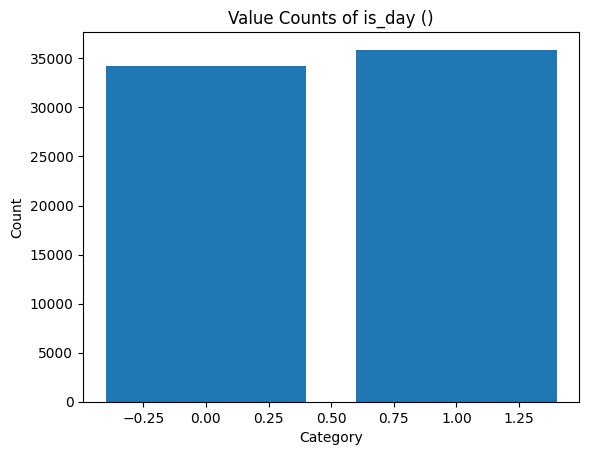

In [242]:


# Assuming df['is_day ()'] contains categorical data
value_counts_is_day = df['is_day ()'].value_counts()

# Create a bar chart
plt.bar(value_counts_is_day.index, value_counts_is_day.values)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of is_day ()')

# Show the plot
plt.show()


In [243]:
df['month'].value_counts()

month
10    5960
1     5952
3     5952
5     5952
7     5952
8     5952
12    5952
4     5760
6     5760
9     5760
11    5760
2     5424
Name: count, dtype: int64

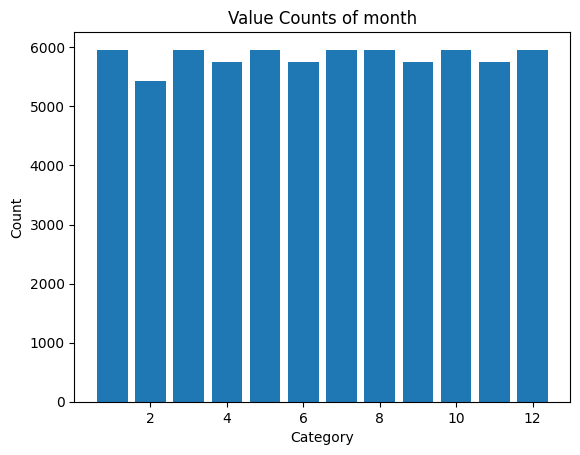

In [244]:
# Assuming df['is_day ()'] contains categorical data
value_counts_month = df['month'].value_counts()

# Create a bar chart
plt.bar(value_counts_month.index, value_counts_month.values)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of month')

# Show the plot
plt.show()

In [245]:
df.head()

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,is_day (),month,total_energy_generated
0,3.7,96,3.1,0.0,1031.5,1025.7,84,61,48,0,0.0,0.03,28.5,280,25.2,0,1,0.35399
1,3.6,95,2.9,0.0,1031.7,1025.9,62,39,27,34,0.0,0.04,28.5,283,25.6,0,1,0.36186
2,3.3,94,2.5,0.0,1032.0,1026.2,100,62,52,49,0.0,0.04,28.2,284,26.3,0,1,0.36784
3,2.9,94,2.0,0.0,1032.2,1026.3,80,31,71,32,0.0,0.05,27.4,280,26.6,0,1,0.36587
4,2.3,94,1.4,0.0,1032.1,1026.2,75,46,44,25,0.0,0.04,26.1,276,26.6,0,1,0.36816


In [246]:
df.columns.to_list()

['temperature',
 'humidity',
 'dewpoint',
 'precipitation',
 'pressure',
 'surface_pressure',
 'cloudcover',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_high',
 'evapotranspiration',
 'vapor_pressure_deficit',
 'windspeed',
 'winddirection',
 'windgusts',
 'is_day ()',
 'month',
 'total_energy_generated']

In [247]:
df.corr()

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,is_day (),month,total_energy_generated
temperature,1.000000,-0.609290,0.856644,-0.053884,-0.086130,-0.068876,-0.222910,-0.327400,-0.011020,0.037749,0.655125,0.793864,-0.205221,-0.014293,0.047991,0.353035,0.215637,-0.239620
humidity,-0.609290,1.000000,-0.124819,0.163649,-0.056407,-0.066912,0.329732,0.397588,0.094719,0.109371,-0.760947,-0.848006,0.070133,0.080268,-0.238391,-0.401826,0.086986,0.092359
dewpoint,0.856644,-0.124819,1.000000,0.030665,-0.144237,-0.129420,-0.070604,-0.165544,0.047178,0.120100,0.306756,0.409013,-0.194767,0.036078,-0.078279,0.185978,0.319504,-0.227805
precipitation,-0.053884,0.163649,0.030665,1.000000,-0.204535,-0.205723,0.216378,0.174976,0.290356,0.154693,-0.079186,-0.111382,0.113025,0.009980,0.128058,0.010655,-0.041289,0.126671
pressure,-0.086130,-0.056407,-0.144237,-0.204535,1.000000,0.999845,-0.205808,-0.034013,-0.308283,-0.254704,0.002861,-0.007088,-0.276104,-0.057780,-0.283850,-0.004714,0.012694,-0.355631
surface_pressure,-0.068876,-0.066912,-0.129420,-0.205723,0.999845,1.000000,-0.209885,-0.039661,-0.308855,-0.254378,0.014062,0.006431,-0.279981,-0.058031,-0.283381,0.001385,0.016556,-0.360221
cloudcover,-0.222910,0.329732,-0.070604,0.216378,-0.205808,-0.209885,1.000000,0.788212,0.663930,0.398495,-0.204200,-0.297336,0.172951,0.133191,0.217437,0.004556,0.022793,0.186899
cloudcover_low,-0.327400,0.397588,-0.165544,0.174976,-0.034013,-0.039661,0.788212,1.000000,0.269049,0.017998,-0.242612,-0.355715,0.148343,0.118191,0.178381,-0.016546,0.011400,0.131386
cloudcover_mid,-0.011020,0.094719,0.047178,0.290356,-0.308283,-0.308855,0.663930,0.269049,1.000000,0.367180,-0.057268,-0.083043,0.176585,0.073646,0.214711,0.031523,-0.007686,0.209225
cloudcover_high,0.037749,0.109371,0.120100,0.154693,-0.254704,-0.254378,0.398495,0.017998,0.367180,1.000000,-0.080312,-0.063836,0.084087,-0.004579,0.042030,-0.031764,0.060695,0.141818


### We see above that there are some columns which has less correlation patterns with the target variable. The next steps will be to explore the individual columns and see what we discover in terms of how the data is distributed. We shall look for potential outliers as well.

<Axes: >

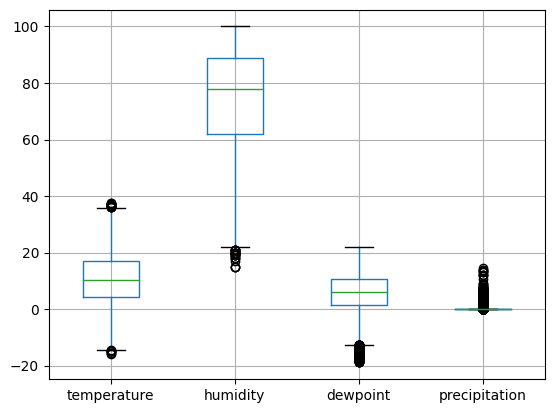

In [248]:
# check boxplots of all the columns

df.boxplot(['temperature',
 'humidity',
 'dewpoint',
 'precipitation'])

<Axes: >

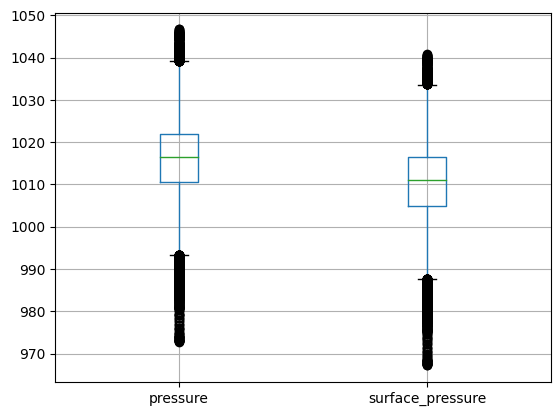

In [249]:
df.boxplot(['pressure',
 'surface_pressure'])

<Axes: >

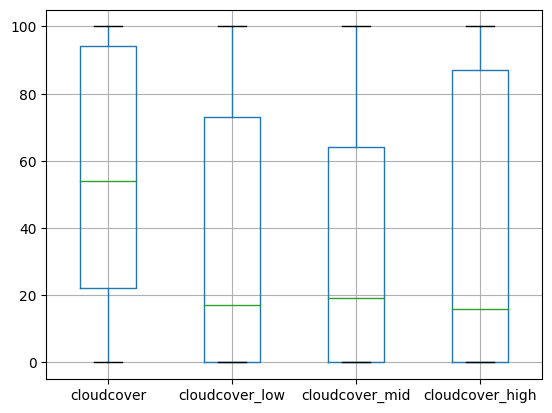

In [250]:
df.boxplot(['cloudcover',
 'cloudcover_low',
 'cloudcover_mid',
 'cloudcover_high'])

<Axes: >

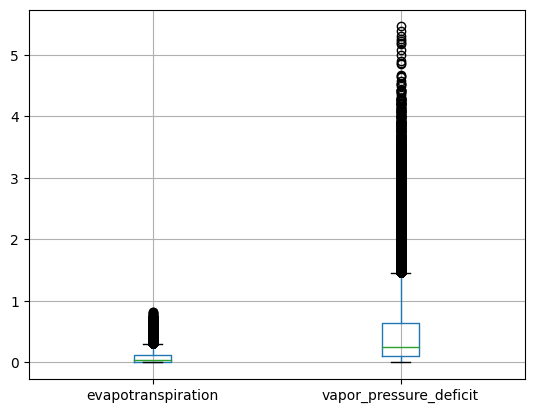

In [251]:
df.boxplot(['evapotranspiration',
 'vapor_pressure_deficit'])

<Axes: >

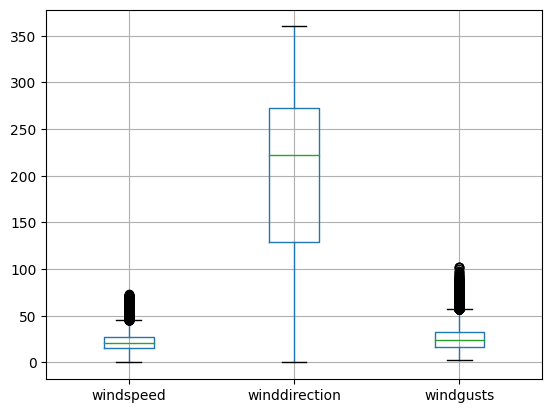

In [252]:
df.boxplot([
 'windspeed',
 'winddirection',
 'windgusts'])

<Axes: >

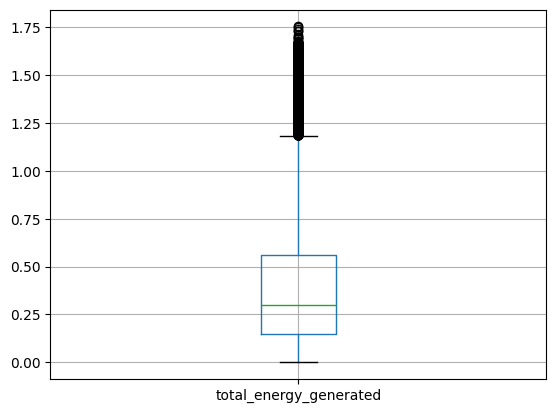

In [253]:
df.boxplot('total_energy_generated')

### We have identified the columns with many outliers and these are the columns that have low correlation patterns with the target variable. Therefore a process called winsorization will be done for these to see if any correlation can be acheived.

In [254]:
import numpy as np
import pandas as pd

# Define the lower and upper threshold percentiles
lower_percentile = 5
upper_percentile = 95

# Create a list of columns you want to Winsorize
columns_to_winsorize = ['humidity', 'pressure', 'surface_pressure', 'dewpoint','precipitation','evapotranspiration',
 'vapor_pressure_deficit']  # Add the column names you want to process

# Loop through the specified columns and apply Winsorization
for column in columns_to_winsorize:
    lower_threshold = np.percentile(df[column], lower_percentile)
    upper_threshold = np.percentile(df[column], upper_percentile)
    
    # Apply Winsorization to the current column
    df[column] = df[column].clip(lower_threshold, upper_threshold)



In [255]:
corr_matrix = df.corr()
rounded_correlation_matrix = corr_matrix.round(2)
rounded_correlation_matrix

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,is_day (),month,total_energy_generated
temperature,1.00,-0.60,0.86,-0.06,-0.09,-0.07,-0.22,-0.33,-0.01,0.04,0.66,0.82,-0.21,-0.01,0.05,0.35,0.22,-0.24
humidity,-0.60,1.00,-0.15,0.23,-0.05,-0.06,0.33,0.40,0.09,0.11,-0.77,-0.88,0.07,0.08,-0.24,-0.40,0.09,0.09
dewpoint,0.86,-0.15,1.00,0.06,-0.14,-0.13,-0.08,-0.18,0.04,0.11,0.32,0.46,-0.20,0.02,-0.08,0.19,0.32,-0.23
precipitation,-0.06,0.23,0.06,1.00,-0.27,-0.27,0.33,0.25,0.43,0.21,-0.11,-0.17,0.17,0.03,0.20,0.02,-0.04,0.20
pressure,-0.09,-0.05,-0.14,-0.27,1.00,1.00,-0.20,-0.03,-0.31,-0.26,-0.00,-0.01,-0.27,-0.06,-0.28,-0.01,0.02,-0.36
surface_pressure,-0.07,-0.06,-0.13,-0.27,1.00,1.00,-0.21,-0.03,-0.31,-0.26,0.01,0.01,-0.27,-0.06,-0.28,-0.00,0.02,-0.36
cloudcover,-0.22,0.33,-0.08,0.33,-0.20,-0.21,1.00,0.79,0.66,0.40,-0.19,-0.31,0.17,0.13,0.22,0.00,0.02,0.19
cloudcover_low,-0.33,0.40,-0.18,0.25,-0.03,-0.03,0.79,1.00,0.27,0.02,-0.24,-0.38,0.15,0.12,0.18,-0.02,0.01,0.13
cloudcover_mid,-0.01,0.09,0.04,0.43,-0.31,-0.31,0.66,0.27,1.00,0.37,-0.05,-0.08,0.18,0.07,0.21,0.03,-0.01,0.21
cloudcover_high,0.04,0.11,0.11,0.21,-0.26,-0.26,0.40,0.02,0.37,1.00,-0.08,-0.07,0.08,-0.00,0.04,-0.03,0.06,0.14


In [256]:
df.describe()

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,total_energy_generated
count,70136.000000,70136.000000,70136.00000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000,70136.000000
mean,10.823041,74.288297,5.88822,0.045751,1016.078584,1010.472568,54.875356,34.988807,33.485186,37.828305,0.085382,0.450117,21.593083,202.014258,25.807229,0.400777
std,8.205413,16.887077,5.73931,0.128306,8.295144,8.237587,36.531930,38.481857,35.932733,41.128342,0.112615,0.470973,9.474781,91.414505,12.227473,0.331988
min,-15.800000,41.000000,-4.30000,0.000000,999.800000,994.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,1.000000,2.200000,0.000000
25%,4.400000,62.000000,1.30000,0.000000,1010.500000,1004.900000,22.000000,0.000000,0.000000,0.000000,0.000000,0.100000,15.000000,129.000000,16.600000,0.148448
50%,10.200000,78.000000,6.00000,0.000000,1016.500000,1011.000000,54.000000,17.000000,19.000000,16.000000,0.030000,0.250000,20.900000,222.000000,24.100000,0.298080
75%,17.000000,89.000000,10.60000,0.000000,1022.000000,1016.400000,94.000000,73.000000,64.000000,87.000000,0.120000,0.640000,27.300000,273.000000,32.800000,0.562480
max,37.500000,96.000000,15.50000,0.500000,1030.800000,1025.000000,100.000000,100.000000,100.000000,100.000000,0.380000,1.680000,73.600000,360.000000,102.600000,1.753470


In [257]:
columns_to_scale = df.columns[:-3].tolist()
scaler = Normalizer()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])


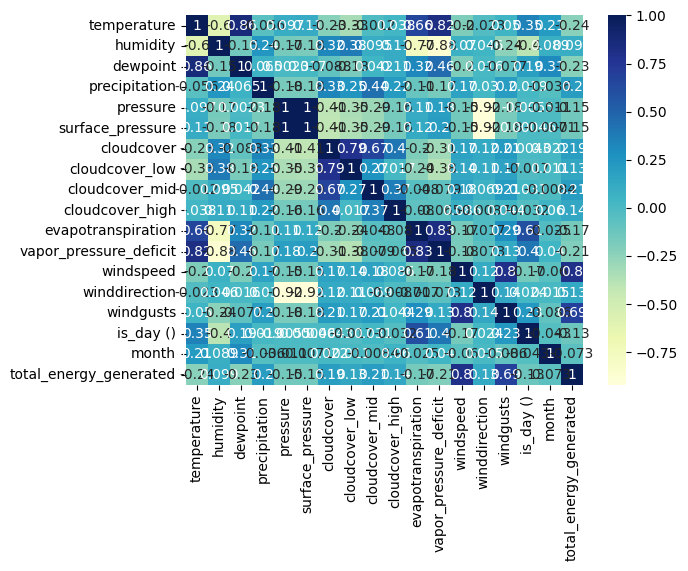

In [258]:
dataplot = sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [259]:
corr_matrix = df.corr()
rounded_correlation_matrix = corr_matrix.round(2)
rounded_correlation_matrix

,temperature,humidity,dewpoint,precipitation,pressure,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,evapotranspiration,vapor_pressure_deficit,windspeed,winddirection,windgusts,is_day (),month,total_energy_generated
temperature,1.00,-0.60,0.86,-0.06,0.10,0.11,-0.23,-0.33,-0.01,0.04,0.66,0.82,-0.20,-0.02,0.05,0.35,0.21,-0.24
humidity,-0.60,1.00,-0.15,0.24,-0.17,-0.18,0.32,0.38,0.10,0.11,-0.77,-0.88,0.07,0.05,-0.24,-0.40,0.09,0.10
dewpoint,0.86,-0.15,1.00,0.06,0.00,0.02,-0.09,-0.18,0.04,0.11,0.32,0.46,-0.20,0.02,-0.08,0.19,0.31,-0.23
precipitation,-0.06,0.24,0.06,1.00,-0.18,-0.18,0.33,0.25,0.44,0.22,-0.11,-0.17,0.17,0.03,0.20,0.02,-0.04,0.20
pressure,0.10,-0.17,0.00,-0.18,1.00,1.00,-0.41,-0.35,-0.29,-0.16,0.11,0.18,-0.15,-0.92,-0.18,-0.01,-0.01,-0.15
surface_pressure,0.11,-0.18,0.02,-0.18,1.00,1.00,-0.41,-0.35,-0.29,-0.16,0.12,0.20,-0.15,-0.92,-0.18,0.00,-0.01,-0.15
cloudcover,-0.23,0.32,-0.09,0.33,-0.41,-0.41,1.00,0.79,0.67,0.40,-0.20,-0.31,0.17,0.12,0.21,0.00,0.02,0.19
cloudcover_low,-0.33,0.38,-0.18,0.25,-0.35,-0.35,0.79,1.00,0.27,0.02,-0.24,-0.38,0.14,0.11,0.17,-0.02,0.01,0.13
cloudcover_mid,-0.01,0.10,0.04,0.44,-0.29,-0.29,0.67,0.27,1.00,0.37,-0.05,-0.08,0.18,0.07,0.21,0.03,-0.01,0.21
cloudcover_high,0.04,0.11,0.11,0.22,-0.16,-0.16,0.40,0.02,0.37,1.00,-0.08,-0.06,0.09,-0.01,0.04,-0.03,0.06,0.14


In [260]:
rounded_correlation_matrix['total_energy_generated']

temperature              -0.24
humidity                  0.10
dewpoint                 -0.23
precipitation             0.20
pressure                 -0.15
surface_pressure         -0.15
cloudcover                0.19
cloudcover_low            0.13
cloudcover_mid            0.21
cloudcover_high           0.14
evapotranspiration       -0.17
vapor_pressure_deficit   -0.21
windspeed                 0.80
winddirection             0.13
windgusts                 0.69
is_day ()                -0.13
month                    -0.07
total_energy_generated    1.00
Name: total_energy_generated, dtype: float64

In [261]:
# remove those columns less than 0.2 absolute value and remove the cloudcover, cloudcover_low and cloudcover_high
df = df.drop('humidity', axis=1)
df = df.drop('cloudcover', axis=1)
df = df.drop('cloudcover_low', axis=1)
df = df.drop('cloudcover_high', axis=1)
df = df.drop('surface_pressure', axis=1)
df = df.drop('pressure', axis=1)
df = df.drop('evapotranspiration', axis=1)
df = df.drop('winddirection', axis=1)

In [262]:
df['total_energy_generated'].describe()

count    70136.000000
mean         0.400777
std          0.331988
min          0.000000
25%          0.148448
50%          0.298080
75%          0.562480
max          1.753470
Name: total_energy_generated, dtype: float64

In [263]:
X = df.drop(columns=['total_energy_generated'], axis=1)
y = df['total_energy_generated']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [264]:
# Ridge Regression
ridge_model = Ridge(alpha=0.3)  # You can adjust the alpha parameter
ridge_model.fit(X_train, y_train)
ridge_y_pred = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)

print("\nRidge Regression:")
print(f"Mean Squared Error: {ridge_mse:.2f}")
print(f"R-squared: {ridge_r2:.2f}")


Ridge Regression:
Mean Squared Error: 0.04
R-squared: 0.66


In [265]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_y_pred = linear_model.predict(X_test)
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_r2 = r2_score(y_test, linear_y_pred)

print("Linear Regression:")
print(f"Mean Squared Error: {linear_mse:.2f}")
print(f"R-squared: {linear_r2:.2f}")

Linear Regression:
Mean Squared Error: 0.04
R-squared: 0.67


In [266]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100)  # You can adjust the number of estimators
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print("\nRandom Forest Regression:")
print(f"Mean Squared Error: {rf_mse:.2f}")
print(f"R-squared: {rf_r2:.2f}")


Random Forest Regression:
Mean Squared Error: 0.02
R-squared: 0.79


windspeed: 0.7316693938107457
temperature: 0.05282647584423921
windgusts: 0.05224424570040407
dewpoint: 0.04286610072700679
vapor_pressure_deficit: 0.03765145509480129
cloudcover_mid: 0.03617422481783877
month: 0.030750998323485032
precipitation: 0.011923165780684008
is_day (): 0.0038939399007951003


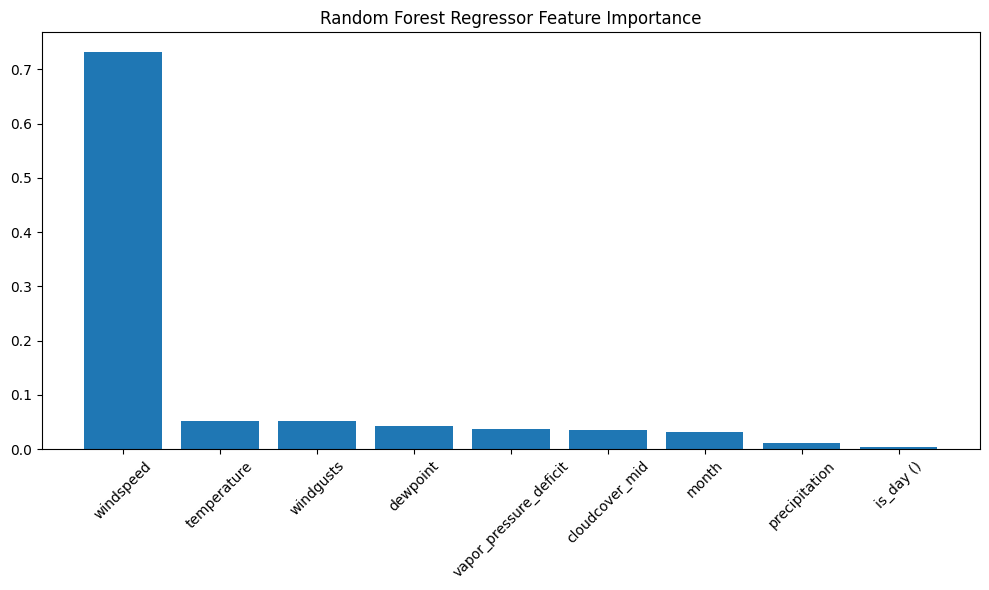

In [267]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Get the names of the features (assuming they are in the same order as in X)
feature_names = X.columns

# Sort the features by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Print the feature importances
for i in sorted_indices:
    print(f"{feature_names[i]}: {feature_importances[i]}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Random Forest Regressor Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feature_names)[sorted_indices], rotation=45)
plt.tight_layout()
plt.show()

In [268]:
# Create a Sequential ANN model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))  # Input layer with 64 neurons and ReLU activation
model.add(Dense(units=32, activation='relu'))  # Hidden layer with 32 neurons and ReLU activation
model.add(Dense(units=16, activation='relu'))  # Hidden layer with 16 neurons and ReLU activation

# Add output layer
model.add(Dense(units=1, activation='linear'))  # Output layer with linear (identity) activation for regression

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')  # Use Mean Squared Error (MSE) as the loss function and Adam optimizer

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)  # Adjust the number of epochs and batch size as needed

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared (R²)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Neural Network (ANN) Regression:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Epoch 1/100
1535/1535 [==============================] - 3s 1ms/step - loss: 0.0793
Epoch 2/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0380
Epoch 3/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0358
Epoch 4/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0354
Epoch 5/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0347
Epoch 6/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0345
Epoch 7/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0342
Epoch 8/100
1535/1535 [==============================] - 2s 2ms/step - loss: 0.0335
Epoch 9/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0329
Epoch 10/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0329
Epoch 11/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.0325
Epoch 12/100
1535/1535 [==============================] - 2s 1ms/step - lo